![Banner](https://i.imgur.com/a3uAqnb.png)

# Variational Autoencoder for Image Attribute Manipulation - Homework Assignment

In this homework, you will implement a **Conditional Variational Autoencoder (CVAE)** using PyTorch to perform image attribute manipulation on the CelebA dataset. This involves learning disentangled representations and using them to modify specific facial attributes like adding glasses or changing hair color.

## 📌 Project Overview
- **Task**: Image attribute manipulation using CVAE
- **Architecture**: Conditional Variational Autoencoder with encoder-decoder structure
- **Dataset**: CelebA (200K+ celebrity face images with 40 attribute annotations)
- **Goal**: Learn to encode/decode images while controlling specific attributes

## 📚 Learning Objectives
By completing this assignment, you will:
- Implement a Conditional Variational Autoencoder architecture
- Work with facial attribute datasets and preprocessing
- Learn about latent space manipulation for attribute control
- Apply reparameterization trick and VAE loss functions
- Evaluate generative models through reconstruction and manipulation quality

## 1️⃣ Dataset Setup and Preprocessing

**Task**: Download and preprocess the CelebA dataset with proper transformations.

**Requirements**:
- Download CelebA dataset using kagglehub
- Create custom dataset class for loading images and attributes
- Implement proper image transformations and normalization
- Set up data loaders for training

In [29]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import numpy as np
import kagglehub

path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

class CelebADataset(Dataset):
    def __init__(self, root_dir, attr_file, transform=None, max_samples=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.attr_df = pd.read_csv(attr_file)
        
        if max_samples:
            self.attr_df = self.attr_df.head(max_samples)
        
        self.attr_names = [col for col in self.attr_df.columns if col != 'image_id']
        
    def __len__(self):
        return len(self.attr_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.attr_df.iloc[idx]['image_id']
        img_path = os.path.join(self.root_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (178, 218), color='black')
        
        attributes = self.attr_df.iloc[idx][self.attr_names].values.astype(np.float32)
        attributes = (attributes + 1) / 2
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(attributes)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

images_dir = os.path.join(path, "img_align_celeba", "img_align_celeba")
attr_file = os.path.join(path, "list_attr_celeba.csv")

dataset = CelebADataset(images_dir, attr_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

## 2️⃣ Implement Conditional Variational Autoencoder

**Task**: Build a CVAE architecture that can encode images conditioned on attributes and decode them back.

**Requirements**:
- Create encoder network that takes image and attributes as input
- Implement reparameterization trick for sampling latent variables
- Build decoder that reconstructs images from latent code and attributes
- Add proper batch normalization and activation functions

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CVAE(nn.Module):
    def __init__(self, input_channels=3, input_size=64, hidden_dim=512, latent_dim=128, condition_dim=40):
        super(CVAE, self).__init__()
        
        self.input_channels = input_channels
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
        )
        
        self.conv_output_size = 256 * 4 * 4
        
        self.condition_embedding = nn.Sequential(
            nn.Linear(condition_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True)
        )
        
        self.encoder_fc = nn.Sequential(
            nn.Linear(self.conv_output_size + 128, hidden_dim),
            nn.ReLU(True),
            nn.Dropout(0.2)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim + 128, hidden_dim),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, self.conv_output_size),
            nn.ReLU(True),
        )
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )
    
    def encode(self, x, c):
        conv_features = self.encoder_conv(x)
        conv_features = conv_features.view(conv_features.size(0), -1)
        
        c_embedded = self.condition_embedding(c)
        
        combined = torch.cat([conv_features, c_embedded], dim=1)
        hidden = self.encoder_fc(combined)
        
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
    
    def decode(self, z, c):
        c_embedded = self.condition_embedding(c)
        
        combined = torch.cat([z, c_embedded], dim=1)
        
        decoded_flat = self.decoder_fc(combined)
        decoded_reshaped = decoded_flat.view(decoded_flat.size(0), 256, 4, 4)
        reconstructed = self.decoder_conv(decoded_reshaped)
        
        return reconstructed
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    
    def sample(self, c, num_samples=1, device='cpu'):
        self.eval()
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim).to(device)
            if c.shape[0] != num_samples:
                c = c.repeat(num_samples, 1)
            samples = self.decode(z, c)
        return samples

def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    batch_size = x.size(0)
    
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss / batch_size, recon_loss / batch_size, kl_loss / batch_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE().to(device)

## 3️⃣ Training Configuration and Loop

**Task**: Set up training parameters and implement the main training loop with proper scheduling.

**Requirements**:
- Configure training hyperparameters including β-VAE scheduling
- Implement training loop with loss tracking and visualization
- Save model checkpoints and sample images during training
- Monitor reconstruction quality and loss curves

Epoch 5/50: 100%|█████████████████| 1583/1583 [02:00<00:00, 13.16it/s, Total=766.58, Recon=730.55, KL=299.2739, β=0.120]


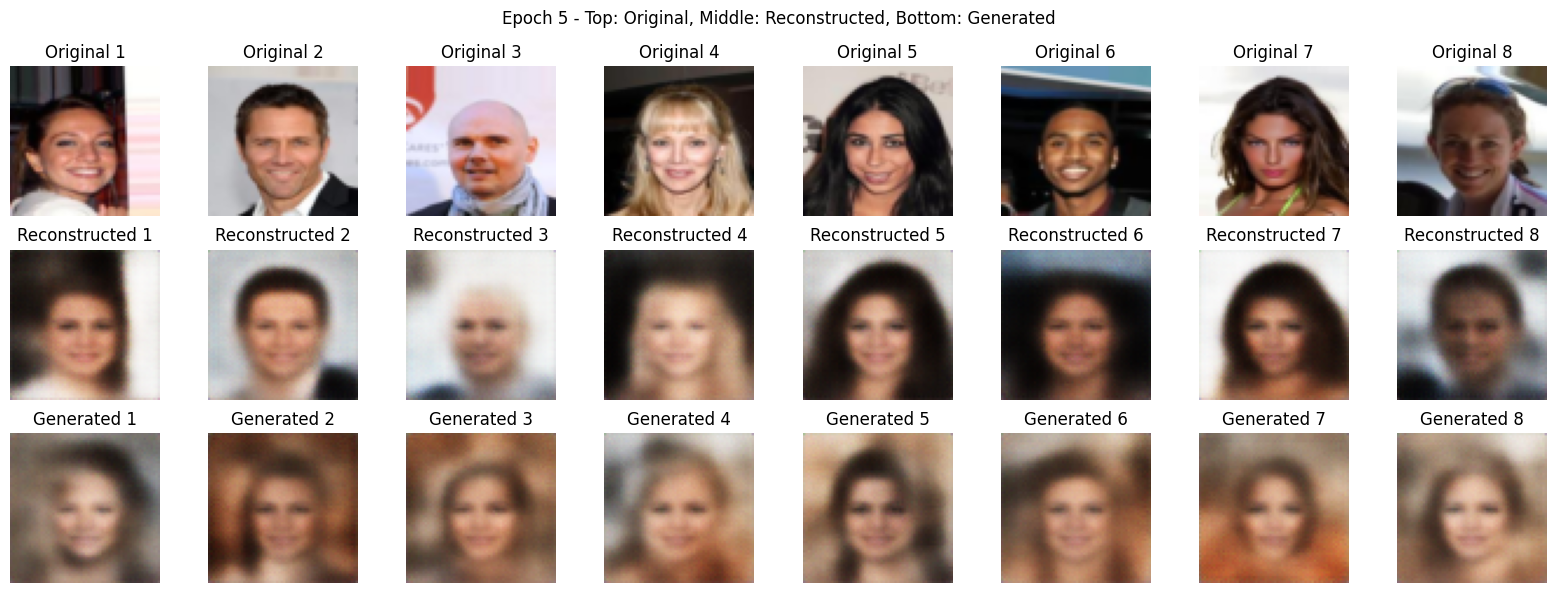

Epoch 10/50: 100%|█████████████████| 1583/1583 [01:36<00:00, 16.34it/s, Total=391.90, Recon=388.35, KL=13.7283, β=0.258]


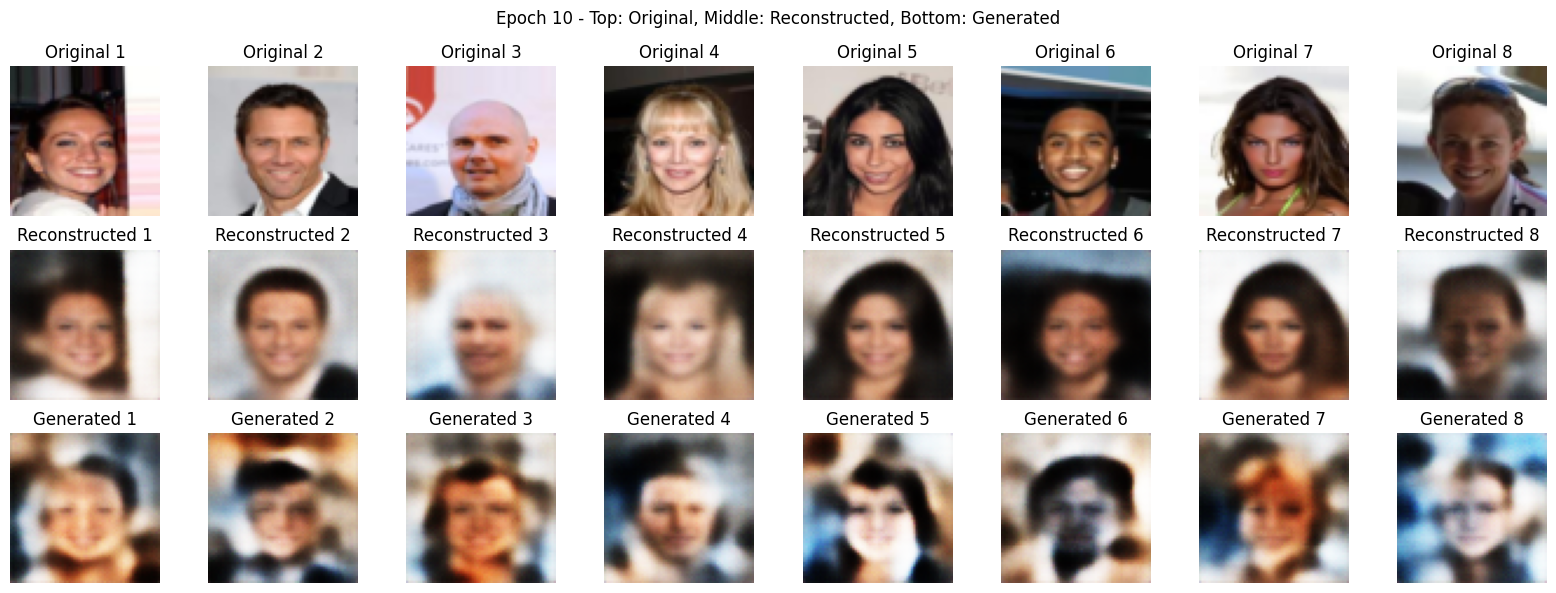

Epoch 15/50: 100%|██████████████████| 1583/1583 [01:27<00:00, 18.10it/s, Total=325.17, Recon=322.09, KL=7.7528, β=0.396]


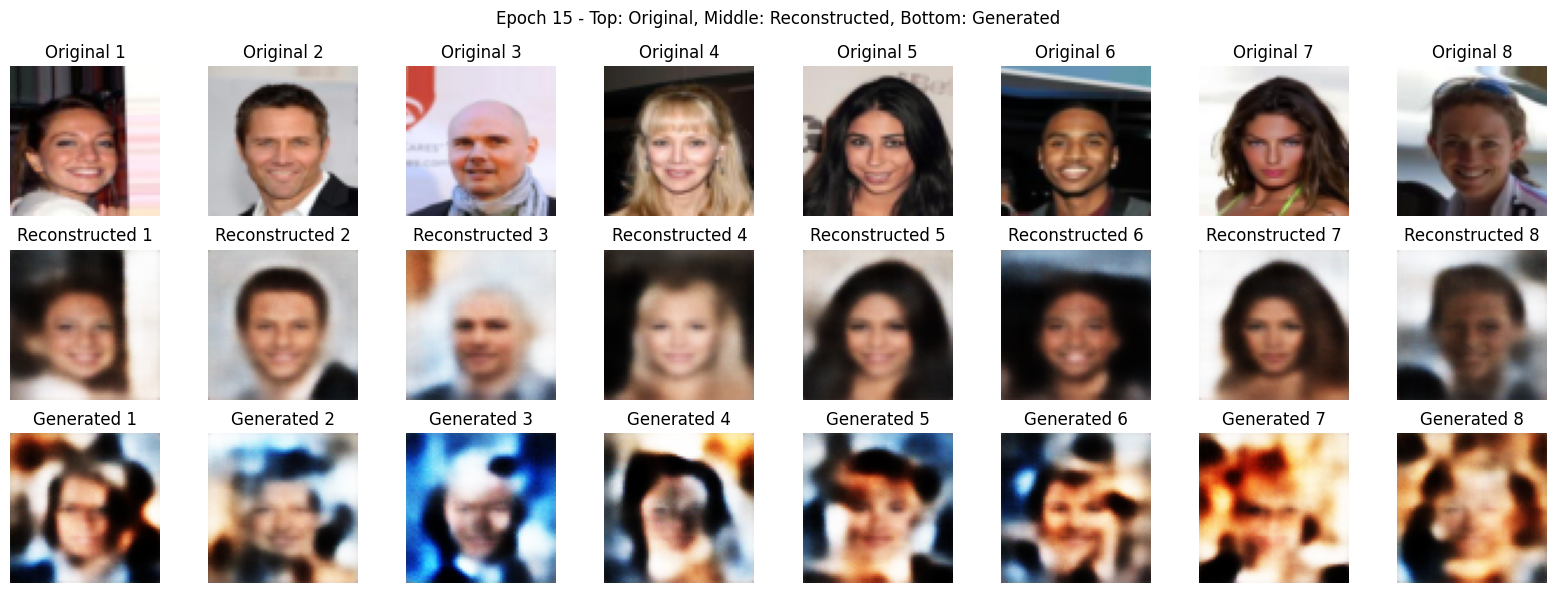

Epoch 20/50: 100%|██████████████████| 1583/1583 [04:33<00:00,  5.78it/s, Total=345.23, Recon=342.04, KL=5.9765, β=0.534]


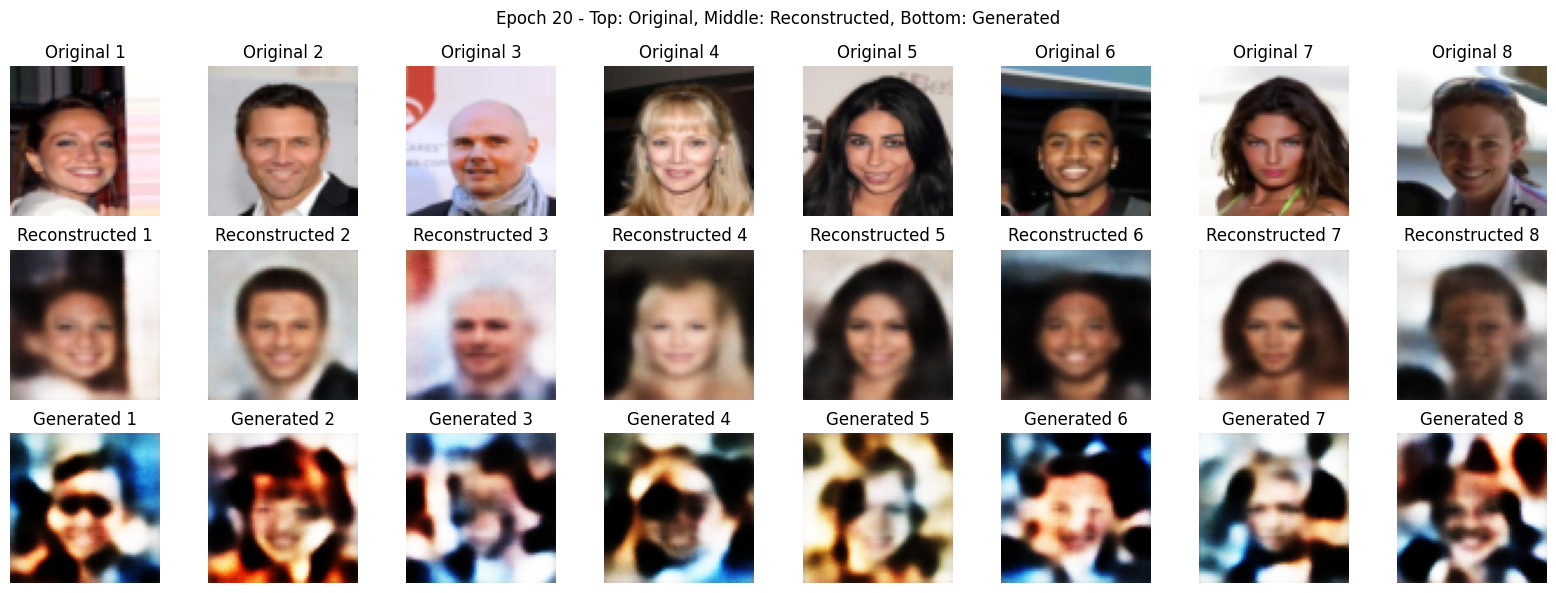

Epoch 25/50: 100%|██████████████████| 1583/1583 [01:36<00:00, 16.44it/s, Total=293.72, Recon=290.90, KL=4.2054, β=0.672]


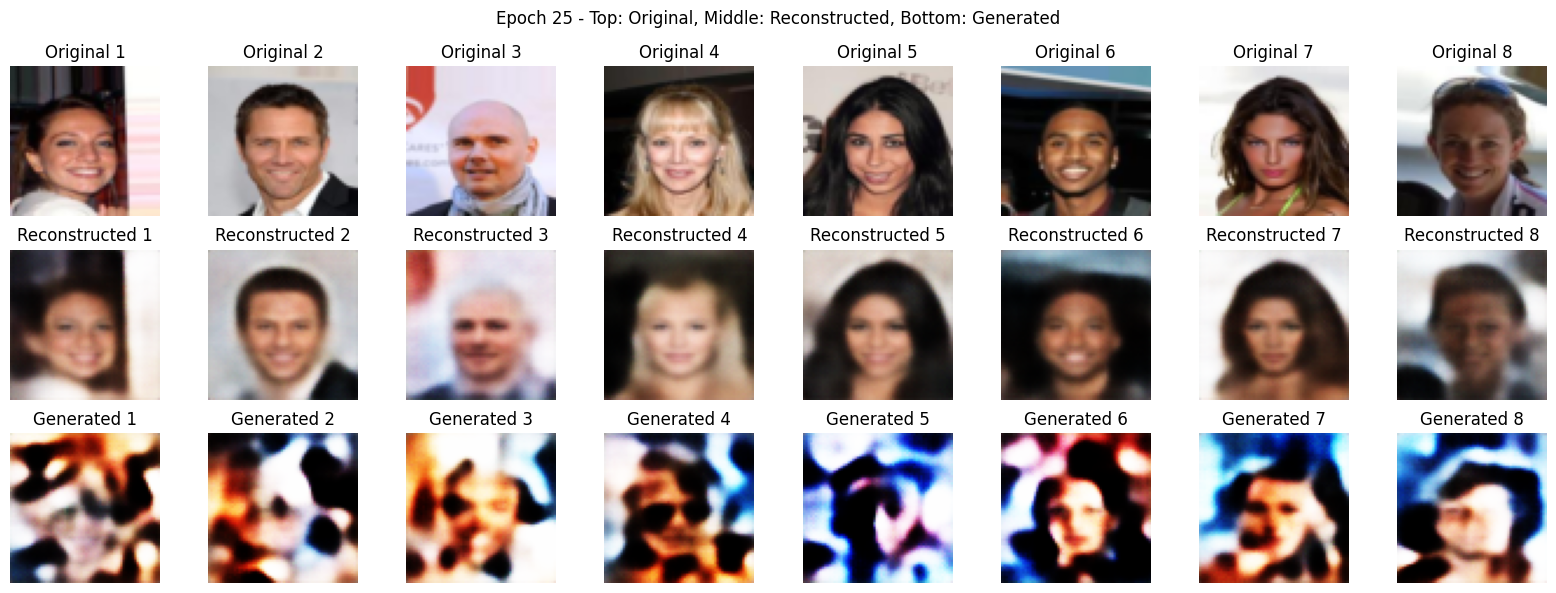

Epoch 27/50:  17%|███▏               | 268/1583 [00:15<01:14, 17.61it/s, Total=263.52, Recon=260.51, KL=4.3049, β=0.700]


KeyboardInterrupt: 

In [31]:
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

config = {
    'num_epochs': 50,
    'learning_rate': 2e-5,  
    'beta_start': 0.01,
    'beta_end': .7,
    'beta_warmup_epochs': 25,
    'save_interval': 5,
    'log_interval': 50,
}

optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], betas=(0.9, 0.999))

train_history = {
    'total_loss': [],
    'recon_loss': [],
    'kl_loss': [],
    'beta_values': []
}

def get_beta(epoch, config):
    if epoch < config['beta_warmup_epochs']:
        beta = config['beta_start'] + (config['beta_end'] - config['beta_start']) * (epoch / config['beta_warmup_epochs'])
    else:
        beta = config['beta_end']
    return beta

def save_sample_images(model, test_data, epoch, device, num_samples=8):
    model.eval()
    with torch.no_grad():
        test_images, test_labels = test_data
        test_images = test_images[:num_samples].to(device)
        test_labels = test_labels[:num_samples].to(device)
        
        recon_images, _, _ = model(test_images, test_labels)
        generated = model.sample(test_labels, num_samples=num_samples, device=device)
        
        fig, axes = plt.subplots(3, num_samples, figsize=(16, 6))
        
        for i in range(num_samples):
            img_orig = (test_images[i].cpu() * 0.5 + 0.5).clamp(0, 1)
            axes[0, i].imshow(img_orig.permute(1, 2, 0))
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            img_recon = (recon_images[i].cpu() * 0.5 + 0.5).clamp(0, 1)
            axes[1, i].imshow(img_recon.permute(1, 2, 0))
            axes[1, i].set_title(f'Reconstructed {i+1}')
            axes[1, i].axis('off')
            
            img_gen = (generated[i].cpu() * 0.5 + 0.5).clamp(0, 1)
            axes[2, i].imshow(img_gen.permute(1, 2, 0))
            axes[2, i].set_title(f'Generated {i+1}')
            axes[2, i].axis('off')
        
        plt.suptitle(f'Epoch {epoch} - Top: Original, Middle: Reconstructed, Bottom: Generated')
        plt.tight_layout()
        plt.show()

test_batch = next(iter(dataloader))

model.train()
for epoch in range(config['num_epochs']):
    epoch_total_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0
    num_batches = 0
    
    current_beta = get_beta(epoch, config)
    
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        recon_images, mu, logvar = model(images, labels)
        total_loss, recon_loss, kl_loss = cvae_loss(recon_images, images, mu, logvar, beta=current_beta)
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_total_loss += total_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()
        num_batches += 1
        
        pbar.set_postfix({
            'Total': f'{total_loss.item():.2f}',
            'Recon': f'{recon_loss.item():.2f}',
            'KL': f'{kl_loss.item():.4f}',
            'β': f'{current_beta:.3f}'
        })
    
    avg_total_loss = epoch_total_loss / num_batches
    avg_recon_loss = epoch_recon_loss / num_batches
    avg_kl_loss = epoch_kl_loss / num_batches
    
    train_history['total_loss'].append(avg_total_loss)
    train_history['recon_loss'].append(avg_recon_loss)
    train_history['kl_loss'].append(avg_kl_loss)
    train_history['beta_values'].append(current_beta)
    
    if (epoch + 1) % config['save_interval'] == 0:
        save_sample_images(model, test_batch, epoch + 1, device)
    
    if (epoch + 1) % config['save_interval'] == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_history': train_history,
            'config': config
        }
        torch.save(checkpoint, f'cvae_checkpoint_epoch_{epoch+1}.pth')

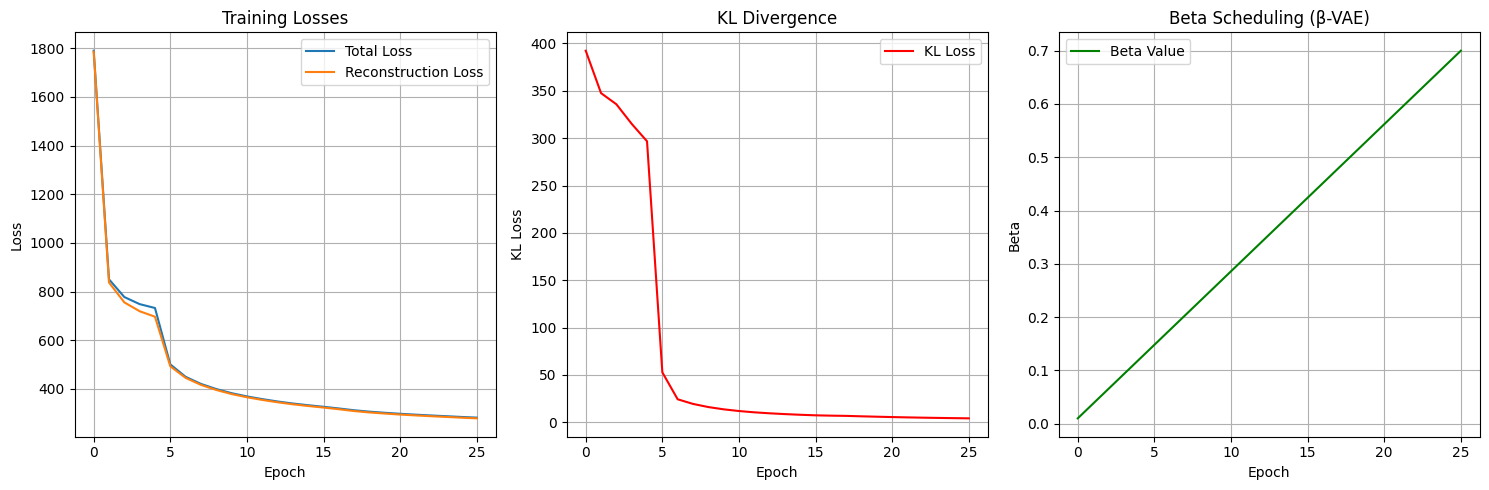

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_history['total_loss'], label='Total Loss')
plt.plot(train_history['recon_loss'], label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_history['kl_loss'], label='KL Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('KL Loss')
plt.title('KL Divergence')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_history['beta_values'], label='Beta Value', color='green')
plt.xlabel('Epoch')
plt.ylabel('Beta')
plt.title('Beta Scheduling (β-VAE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

torch.save({
    'model_state_dict': model.state_dict(),
    'train_history': train_history,
    'config': config
}, 'cvae_final_model.pth')

## 4️⃣ Attribute Manipulation and Evaluation

**Task**: Implement attribute manipulation functionality and evaluate the model's performance.

**Requirements**:
- Create functions to manipulate specific facial attributes
- Test manipulation on various attributes (smiling, glasses, hair color, etc.)
- Visualize before/after comparisons for attribute changes


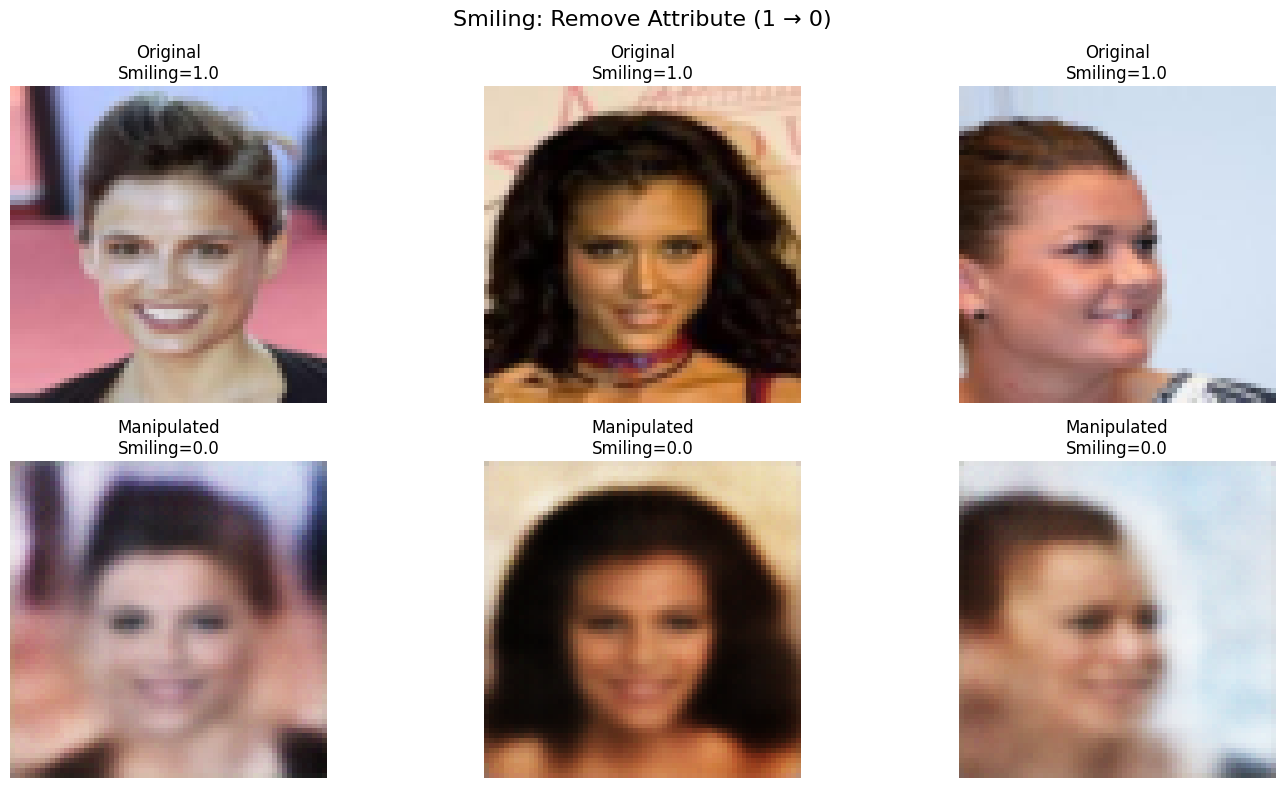

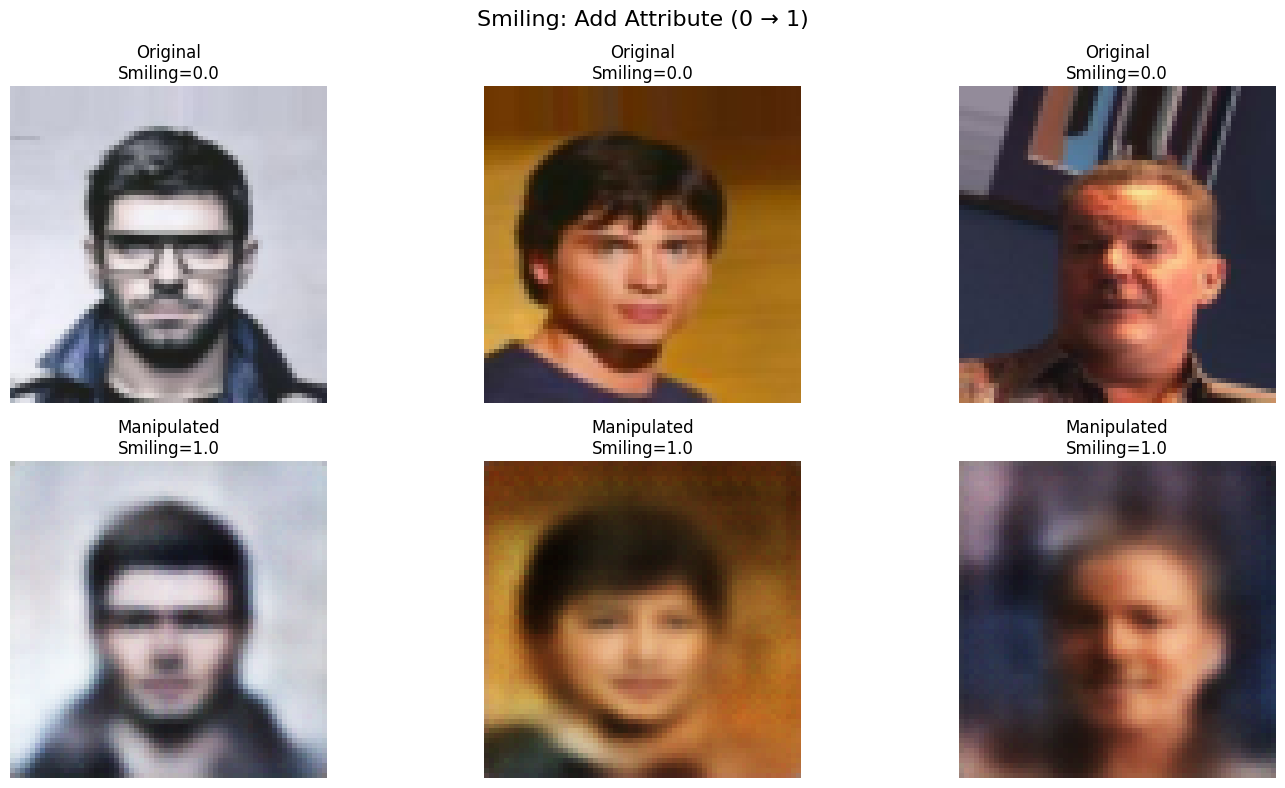

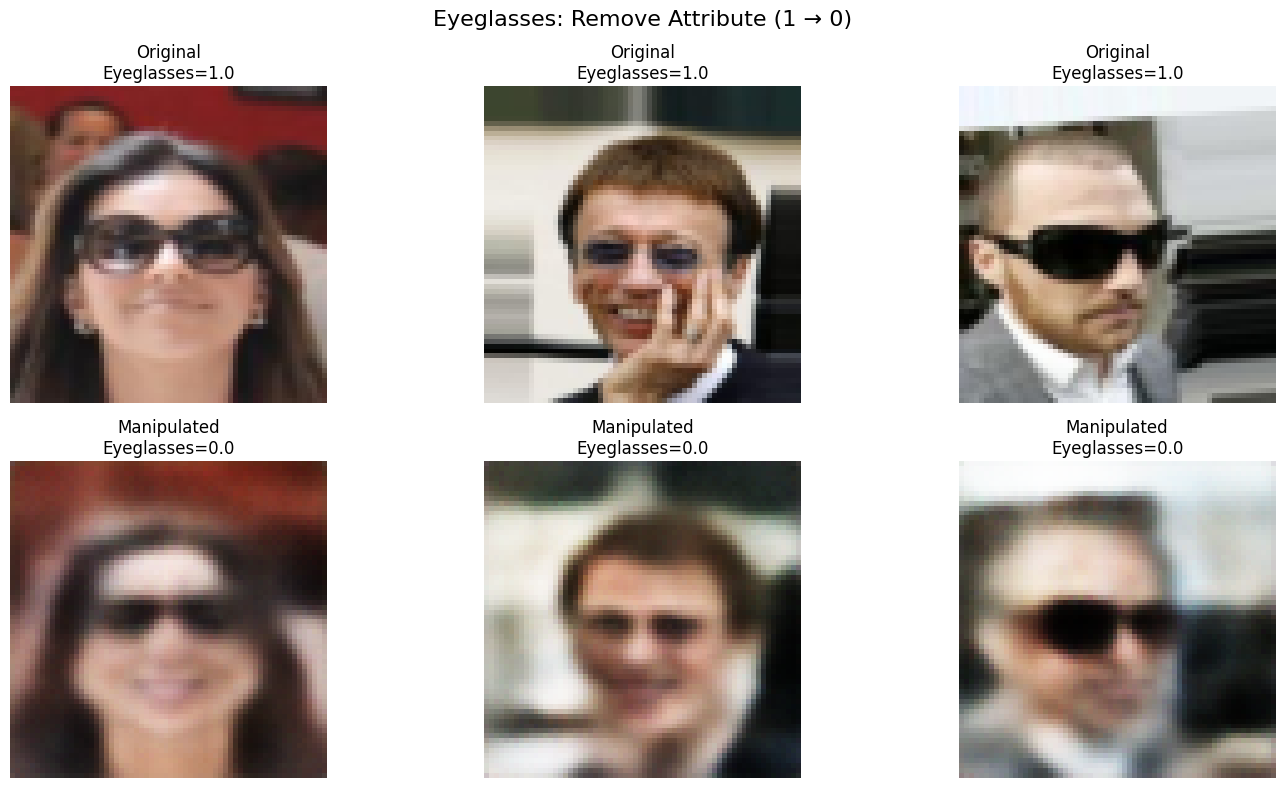

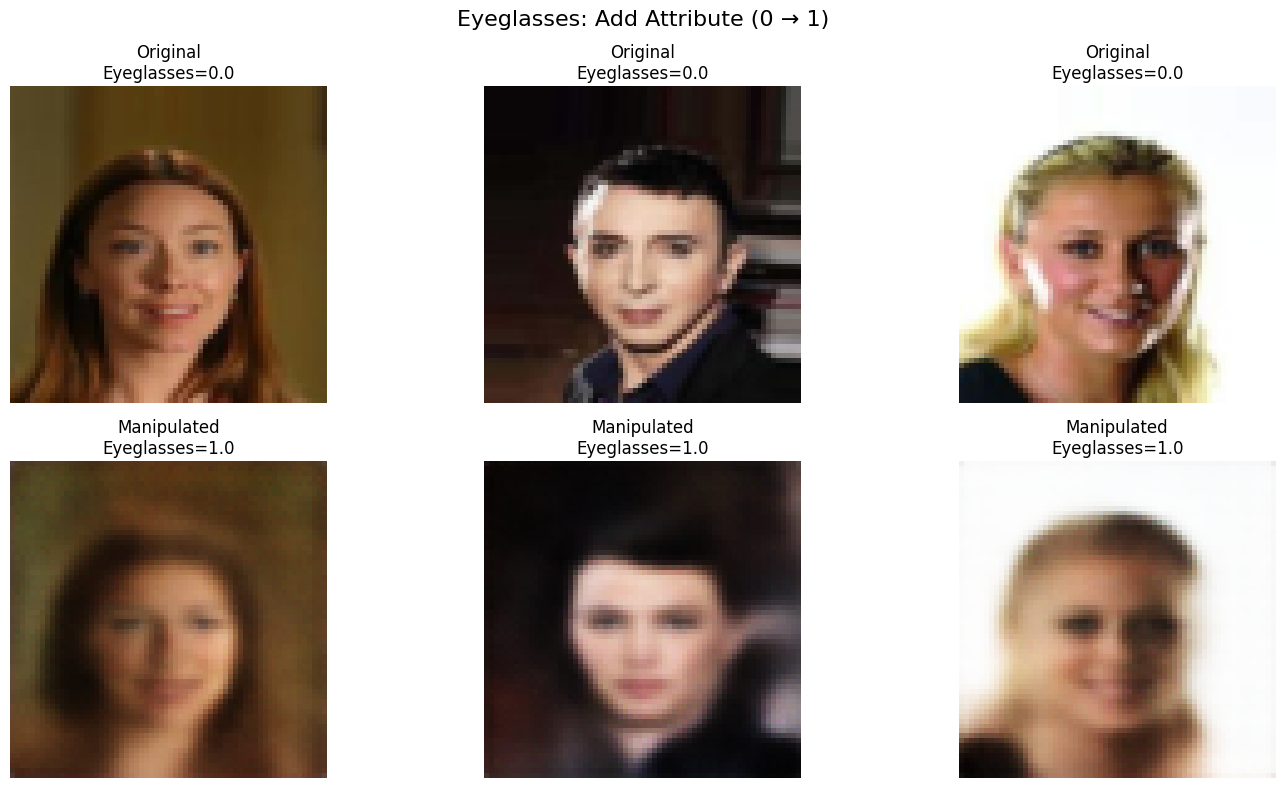

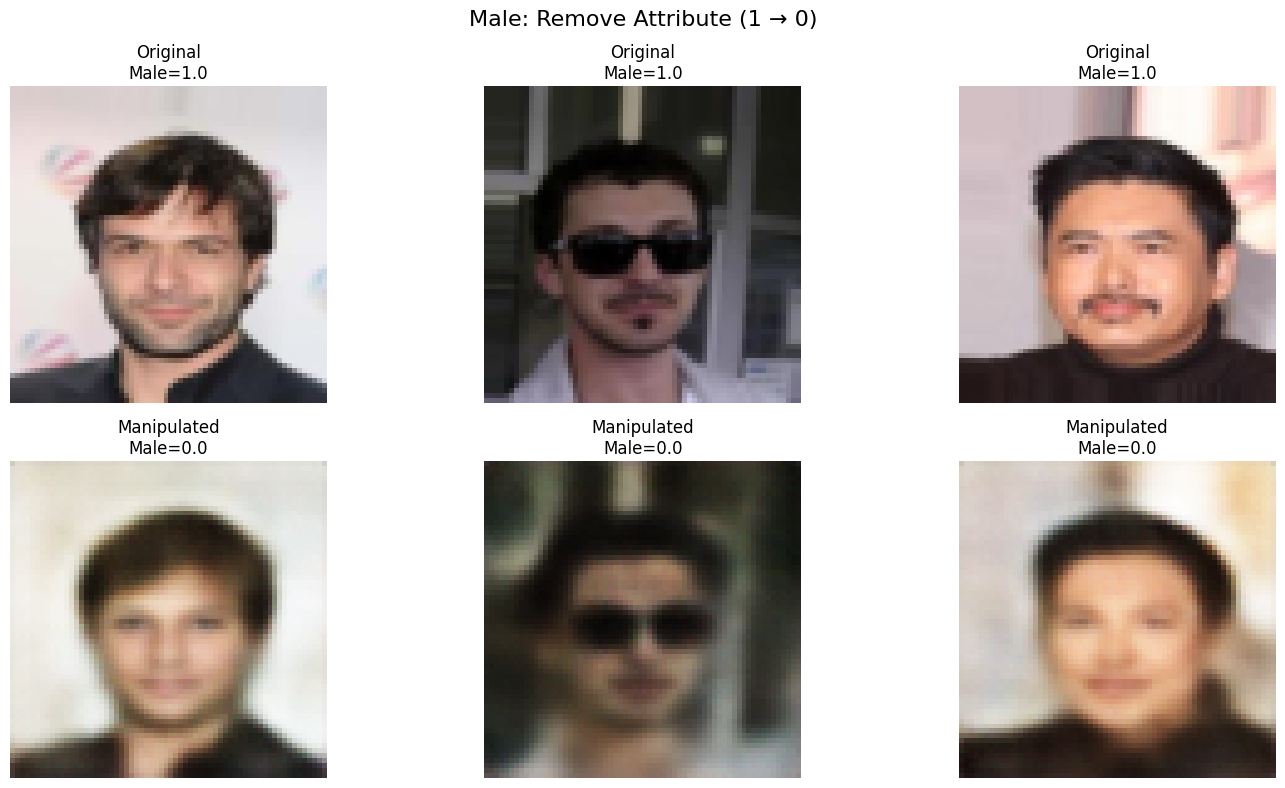

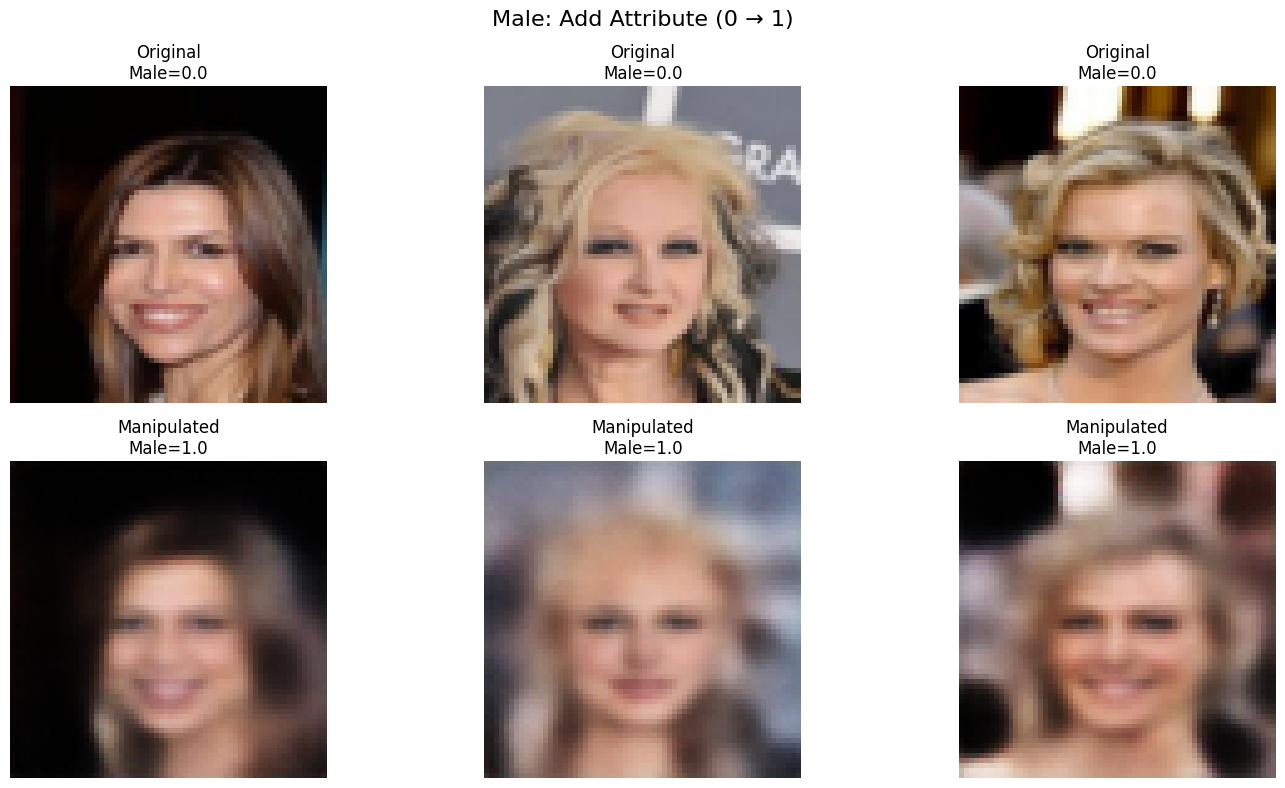

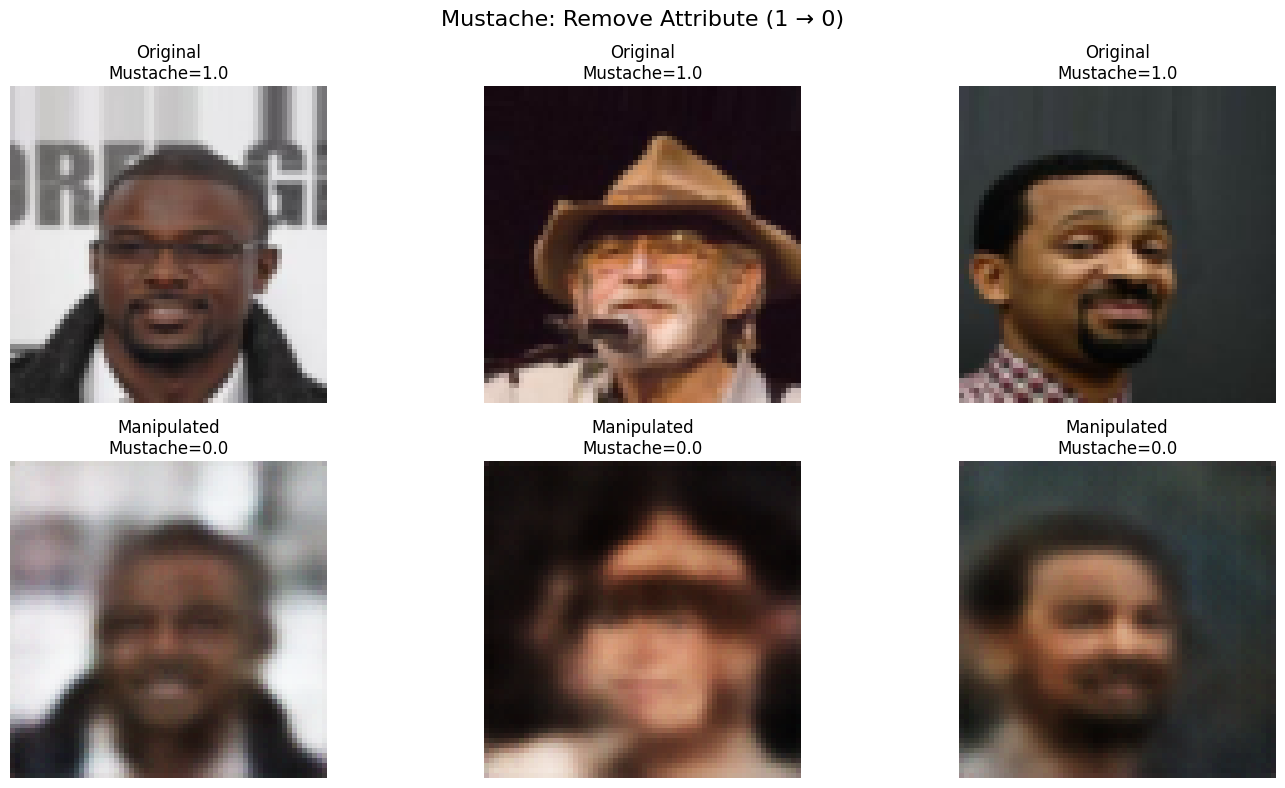

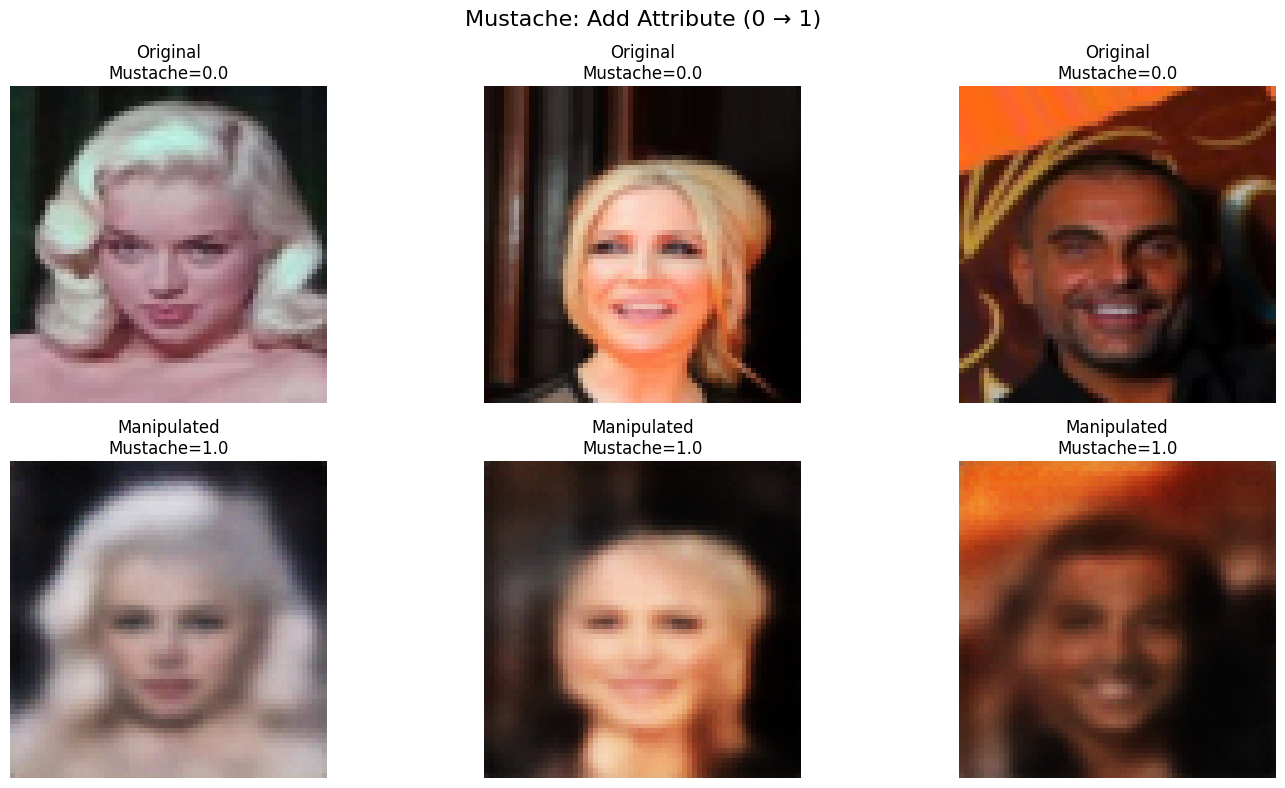

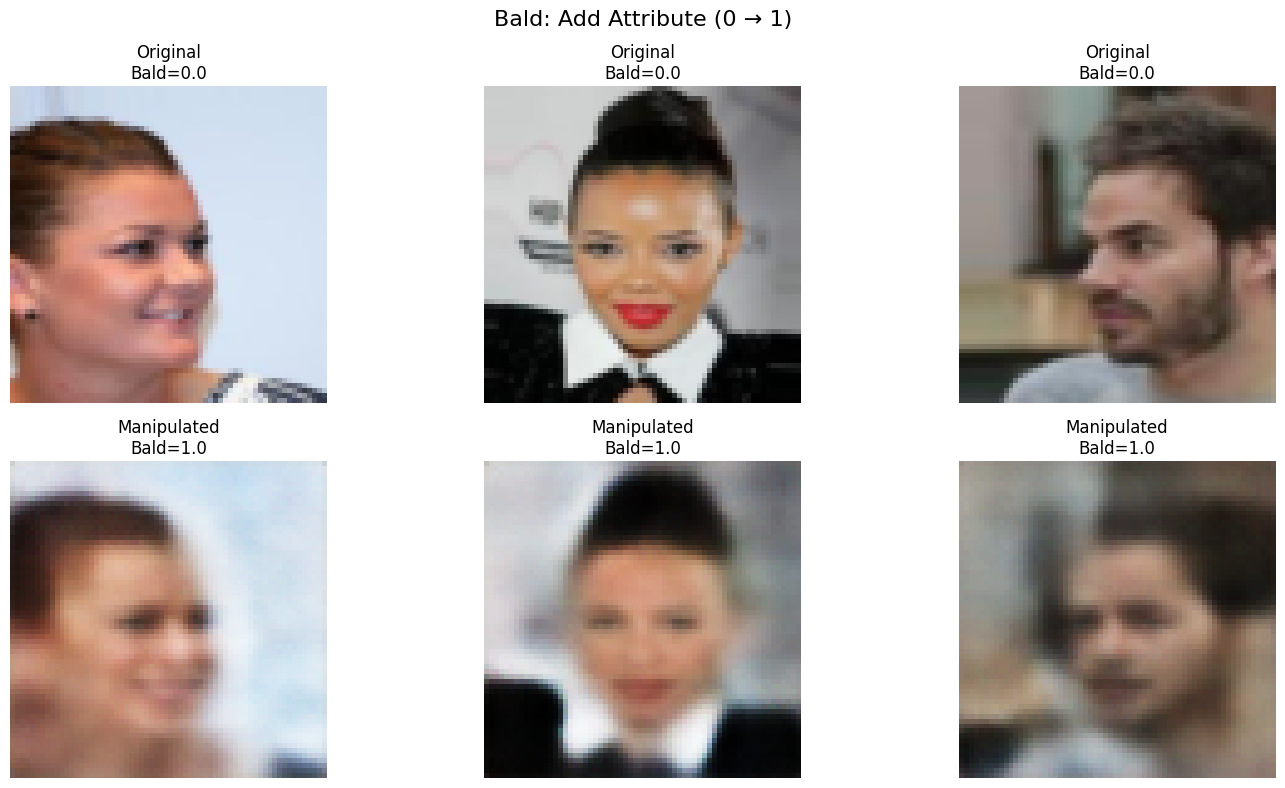

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

model.eval()

attr_names = dataset.attr_names

important_attrs = {
    'Smiling': attr_names.index('Smiling'),
    'Male': attr_names.index('Male'), 
    'Young': attr_names.index('Young'),
    'Eyeglasses': attr_names.index('Eyeglasses'),
    'Blond_Hair': attr_names.index('Blond_Hair'),
    'Black_Hair': attr_names.index('Black_Hair'),
    'Brown_Hair': attr_names.index('Brown_Hair'),
    'Bangs': attr_names.index('Bangs'),
    'Wavy_Hair': attr_names.index('Wavy_Hair'),
    'Mustache': attr_names.index('Mustache'),
    'Goatee': attr_names.index('Goatee'),
    'Bald': attr_names.index('Bald'),
    'Wearing_Lipstick': attr_names.index('Wearing_Lipstick'),
    'Heavy_Makeup': attr_names.index('Heavy_Makeup'),
    'Attractive': attr_names.index('Attractive')
}

def manipulate_single_attribute(model, image, original_attrs, attr_name, target_value, device):
    if attr_name not in important_attrs:
        return None
    
    attr_idx = important_attrs[attr_name]
    
    with torch.no_grad():
        mu, logvar = model.encode(image, original_attrs)
        z = model.reparameterize(mu, logvar)
        
        new_attrs = original_attrs.clone()
        new_attrs[0, attr_idx] = target_value
        
        manipulated_img = model.decode(z, new_attrs)
    
    return manipulated_img

def show_attribute_manipulation_clean(model, dataloader, attr_name, device, num_examples=3):
    if attr_name not in important_attrs:
        return
    
    attr_idx = important_attrs[attr_name]
    
    images, labels = next(iter(dataloader))
    
    positive_indices = [i for i in range(len(labels)) if labels[i, attr_idx] > 0.5]
    negative_indices = [i for i in range(len(labels)) if labels[i, attr_idx] < 0.5]
    
    if len(positive_indices) >= num_examples:
        fig, axes = plt.subplots(2, num_examples, figsize=(15, 8))
        fig.suptitle(f'{attr_name}: Remove Attribute (1 → 0)', fontsize=16)
        
        for i in range(num_examples):
            idx = positive_indices[i]
            img = images[idx:idx+1].to(device)
            attrs = labels[idx:idx+1].to(device)
            
            orig_img = (img[0].cpu() * 0.5 + 0.5).clamp(0, 1)
            axes[0, i].imshow(orig_img.permute(1, 2, 0))
            axes[0, i].set_title(f'Original\n{attr_name}={attrs[0, attr_idx]:.1f}')
            axes[0, i].axis('off')
            
            manipulated = manipulate_single_attribute(model, img, attrs, attr_name, 0.0, device)
            if manipulated is not None:
                manip_img = (manipulated[0].cpu() * 0.5 + 0.5).clamp(0, 1)
                axes[1, i].imshow(manip_img.permute(1, 2, 0))
                axes[1, i].set_title(f'Manipulated\n{attr_name}=0.0')
                axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{attr_name}_remove.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    if len(negative_indices) >= num_examples:
        fig, axes = plt.subplots(2, num_examples, figsize=(15, 8))
        fig.suptitle(f'{attr_name}: Add Attribute (0 → 1)', fontsize=16)
        
        for i in range(num_examples):
            idx = negative_indices[i]
            img = images[idx:idx+1].to(device)
            attrs = labels[idx:idx+1].to(device)
            
            orig_img = (img[0].cpu() * 0.5 + 0.5).clamp(0, 1)
            axes[0, i].imshow(orig_img.permute(1, 2, 0))
            axes[0, i].set_title(f'Original\n{attr_name}={attrs[0, attr_idx]:.1f}')
            axes[0, i].axis('off')
            
            manipulated = manipulate_single_attribute(model, img, attrs, attr_name, 1.0, device)
            if manipulated is not None:
                manip_img = (manipulated[0].cpu() * 0.5 + 0.5).clamp(0, 1)
                axes[1, i].imshow(manip_img.permute(1, 2, 0))
                axes[1, i].set_title(f'Manipulated\n{attr_name}=1.0')
                axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{attr_name}_add.png', dpi=150, bbox_inches='tight')
        plt.show()

show_attribute_manipulation_clean(model, dataloader, 'Smiling', device)
show_attribute_manipulation_clean(model, dataloader, 'Eyeglasses', device)
show_attribute_manipulation_clean(model, dataloader, 'Male', device)
show_attribute_manipulation_clean(model, dataloader, 'Mustache', device)
show_attribute_manipulation_clean(model, dataloader, 'Bald', device)

## 📝 Evaluation Criteria

Your VAE homework will be evaluated based on:

1. **Implementation Correctness (35%)**
   - Proper CVAE architecture with encoder/decoder
   - Correct implementation of reparameterization trick
   - Working VAE loss function with KL divergence
   - Functional attribute manipulation pipeline

2. **Training and Results (30%)**
   - Model trains successfully without collapse
   - Successful attribute manipulations on key attributes
   - Proper β-VAE scheduling and convergence

3. **Code Quality and Analysis (35%)**
   - Clean, readable code with comprehensive comments
   - Proper visualization of results and training progress